In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
import DarkVerse as dv


In [3]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}



z_min=0.6
z_max=0.7
SM_min=10.5
SM_max=11

# Select Subsample
subsample = dv.Subsample(catalog=t, randoms=randoms, z_min=z_min, z_max=z_max, SM_min=SM_min, SM_max=SM_max, config=config)

# Get Results
results = subsample.get_results()

print(f"Power Law Parameters (A, gamma): {results['power_law_params']}")
print()
#print(f"w_theta: {results['w_theta']}")
#print(f"DD counts: {results['dd_counts']}")
#print(f"DR counts: {results['dr_counts']}")
#print(f"RR counts: {results['rr_counts']}")


The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 41}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


Theta: [0.00317241 0.00340165 0.00389313 0.00423059 0.00469911 0.00519397
 0.00568191 0.00626069 0.00701449 0.00788163 0.00849341 0.0094154
 0.01048927 0.01164329 0.012745   0.01406043 0.0157136  0.01712229
 0.01899922 0.02102186 0.02319001 0.02557916 0.02823048 0.03124308
 0.03462075 0.0383391  0.04238504 0.04679165 0.05166123 0.05699591
 0.06288381 0.06956463 0.07688058 0.08494246 0.09390933 0.10391161
 0.11477441 0.12683367 0.13996554 0.15467796 0.17105874 0.18865625
 0.20863588 0.230575   0.2548745  0.28125596 0.31094265 0.34328646
 0.37980462 0.41969384 0.46347033 0.51142551 0.565708   0.62524692
 0.69078523 0.76324997 0.84243506 0.93025018 1.02878949 1.13705813
 1.25453182 1.38427737 1.52832742 1.68096408]
w_theta: [ 2.28202226e+00  3.50194796e+00  4.94245450e-01  2.09611525e+00
  5.23186221e-01  8.98121050e-01  5.86256174e-01  1.17576015e+00
  9.27465937e-01  3.15128759e-01 -7.15096023e-02  3.92938451e-01
  6.75409407e-01  2.59195606e-01  6.88113555e-01  9.26534698e-01
  3.84276

Errors on w_theta: [0.73818446 0.67080024 0.6098664  0.5545965  0.50449917 0.4589924
 0.41768228 0.38004545 0.34587072 0.3148239  0.28669943 0.26116775
 0.23801052 0.21701342 0.19797867 0.18071091 0.16506073 0.15088267
 0.13801592 0.12623625 0.11535048 0.10525439 0.0960246  0.08755188
 0.07982535 0.07278896 0.06640706 0.06058886 0.05531174 0.0505085
 0.04616694 0.0421653  0.0385267  0.03521238 0.03224704 0.02953658
 0.02707581 0.02481124 0.02273447 0.02064641 0.01856067 0.01690089
 0.01561406 0.01442042 0.0133624  0.01243469 0.0115061  0.01054159
 0.0097582  0.00914587 0.00857367 0.00791966 0.00736048 0.00687587
 0.00637404 0.00597589 0.00562644 0.00539934 0.00529443 0.00533784
 0.00561192 0.00608284 0.00724778 0.01003855]


/tmp/ipykernel_321980/2901281716.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


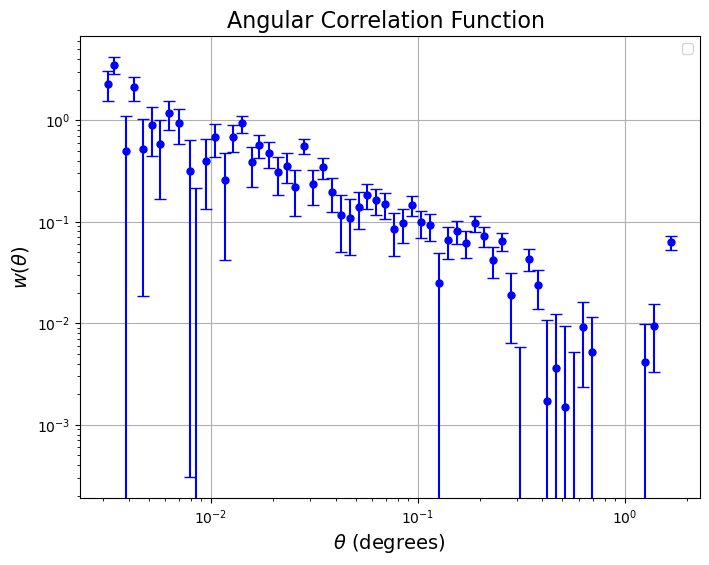

In [4]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)


plt.figure(figsize=(8, 6))
plt.errorbar(theta_values, w_theta_values, yerr= w_theta_errors, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()


### ^these errors are way too big wtf is going on??

In [5]:
gg = subsample.compute_gg()  



In [6]:


# Compute correlation functions
theta, xi_g, xi_m = subsample.compute_gg()

results = subsample.get_results()

#print("Galaxy-Galaxy Angular Correlation:", results['xi_g'])
#print("Matter-Matter Angular Correlation:", results['xi_m'])


Errors on w_theta: [0.73818446 0.67080024 0.6098664  0.5545965  0.50449917 0.4589924
 0.41768228 0.38004545 0.34587072 0.3148239  0.28669943 0.26116775
 0.23801052 0.21701342 0.19797867 0.18071091 0.16506073 0.15088267
 0.13801592 0.12623625 0.11535048 0.10525439 0.0960246  0.08755188
 0.07982535 0.07278896 0.06640706 0.06058886 0.05531174 0.0505085
 0.04616694 0.0421653  0.0385267  0.03521238 0.03224704 0.02953658
 0.02707581 0.02481124 0.02273447 0.02064641 0.01856067 0.01690089
 0.01561406 0.01442042 0.0133624  0.01243469 0.0115061  0.01054159
 0.0097582  0.00914587 0.00857367 0.00791966 0.00736048 0.00687587
 0.00637404 0.00597589 0.00562644 0.00539934 0.00529443 0.00533784
 0.00561192 0.00608284 0.00724778 0.01003855]


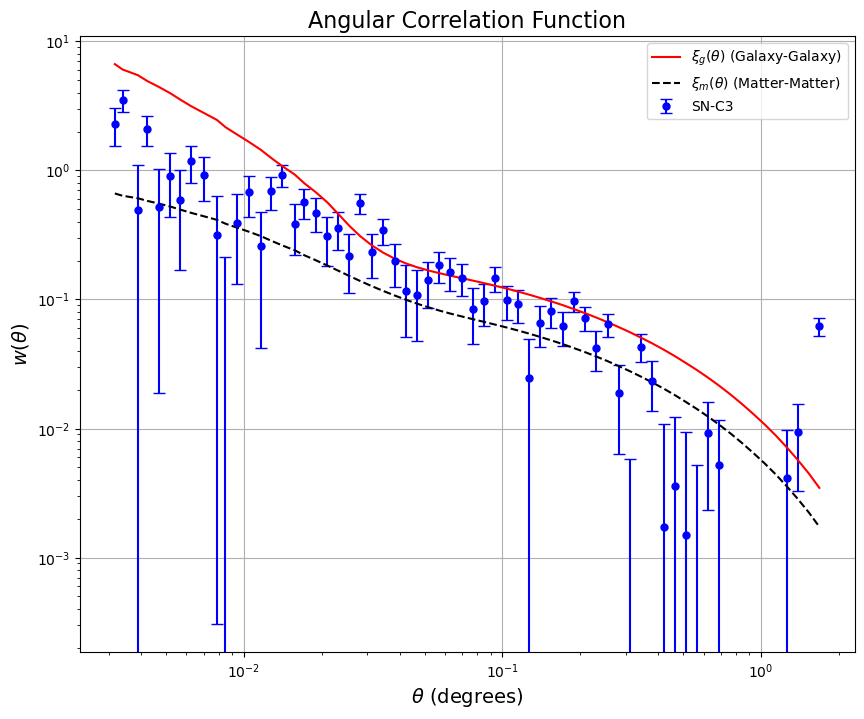

In [7]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']
xi_g_values = results['xi_g']
xi_m_values = results['xi_m']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)

plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


In [8]:


bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list=[results['w_theta']], 
    w_theta_error_list=[results['var_w_theta']], 
    sum_rr_list=[results['rr_counts']], 
    mask = (theta_values >= 0.1) & (theta_values <= 0.4)
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [1.4393500994947226]
Bias errors: [0.0005768282166197863]


In [9]:
xi_m_values = np.array(results['xi_m'])  # Matter-matter correlation function
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction

# Compute the model: xi_m * b^2 - IC
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

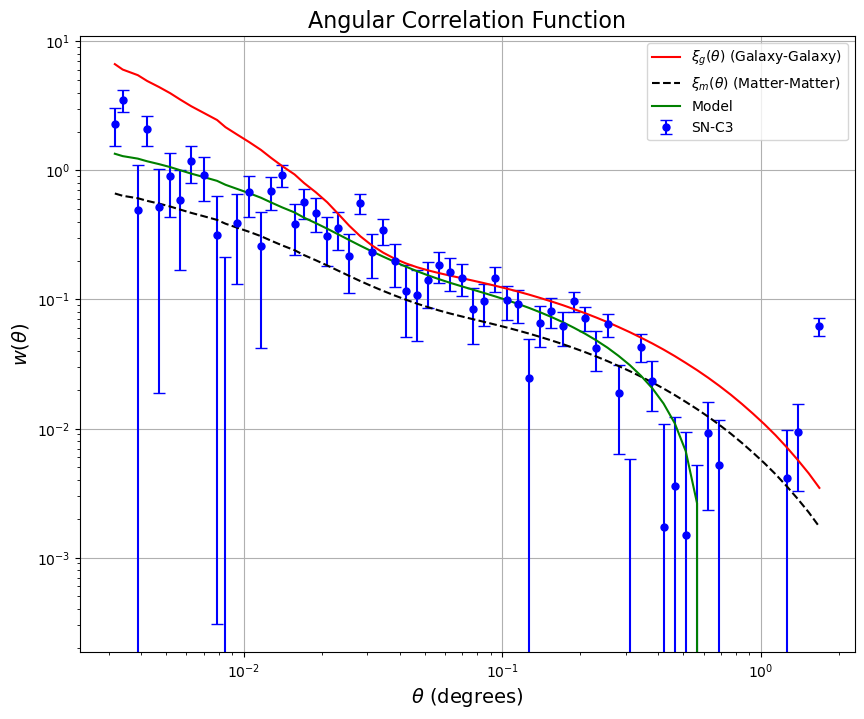

In [10]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [11]:

print("\n--- Subsample Information ---")
print(f"Redshift range: {subsample.z_min} ≤ z ≤ {subsample.z_max}")
print(f"Stellar Mass range: {subsample.SM_min} ≤ SM ≤ {subsample.SM_max}")
print(f"Number of galaxies in subsample: {len(subsample.filtered_catalog)}")



--- Subsample Information ---
Redshift range: 0.6 ≤ z ≤ 0.7
Stellar Mass range: 10.5 ≤ SM ≤ 11
Number of galaxies in subsample: 927


In [12]:


print("\n--- Bootstrap Error Estimations ---")
print("Variance from bootstrap:", results['var_w_theta_bootstrap'])
print("Covariance Matrix:\n", results['covariance_w_theta_bootstrap'])



--- Bootstrap Error Estimations ---
Variance from bootstrap: [4.51898481e+00 6.54373572e+00 1.96639265e+00 2.45533734e+00
 1.05004523e+00 1.56833774e+00 9.26499915e-01 1.12733738e+00
 8.58221563e-01 6.88145534e-01 1.58982622e-01 3.42496011e-01
 3.32272083e-01 2.26493437e-01 2.16697096e-01 2.09861965e-01
 1.62080290e-01 1.09705795e-01 6.65659493e-02 1.01471333e-01
 6.88325146e-02 4.45504520e-02 5.11539971e-02 2.33524084e-02
 3.09272232e-02 2.37873324e-02 1.37812588e-02 1.28506185e-02
 1.14985066e-02 1.01544091e-02 8.74155704e-03 7.65909436e-03
 4.41927014e-03 5.22747666e-03 4.61874675e-03 4.08840033e-03
 2.90078596e-03 1.82957404e-03 1.85278383e-03 1.80016346e-03
 1.62536790e-03 1.12577211e-03 1.34844765e-03 9.40074410e-04
 8.63810109e-04 8.62811786e-04 8.05924885e-04 7.04719425e-04
 4.51976032e-04 4.83224204e-04 4.76636166e-04 2.96900552e-04
 2.36592366e-04 3.68359839e-04 2.80955478e-04 1.96595443e-04
 2.12339030e-04 1.76484464e-04 2.64107244e-04 2.23544722e-04
 1.87869193e-04 2.99543

In [13]:
w_theta_errors_bootstrap= np.sqrt(results['var_w_theta_bootstrap'])

In [14]:
"""bootstrap_w_theta = []

for i in range(100):  
    sample_indices = np.random.choice(len(subsample.filtered_catalog), size=len(subsample.filtered_catalog), replace=True)
    bs_galaxies = subsample.filtered_catalog[sample_indices]
    
    bs_corr = dv.CorrelationFunction(bs_galaxies, randoms, config)
    bs_corr.process()
    w_theta_bs, _, _ ,_, _, _ = bs_corr.calculate_w_theta()
    
    bootstrap_w_theta.append(w_theta_bs)

variance_bootstrap = np.var(bootstrap_w_theta, axis=0)
covariance = np.cov(bootstrap_w_theta)

std_dev= np.std(bootstrap_w_theta, axis=0) #woks better with axis=0 than axis=1 (errors are very big in the latter case)
print(std_dev)
std_dev.shape

print(np.sqrt(variance_bootstrap))

"""

'bootstrap_w_theta = []\n\nfor i in range(100):  \n    sample_indices = np.random.choice(len(subsample.filtered_catalog), size=len(subsample.filtered_catalog), replace=True)\n    bs_galaxies = subsample.filtered_catalog[sample_indices]\n    \n    bs_corr = dv.CorrelationFunction(bs_galaxies, randoms, config)\n    bs_corr.process()\n    w_theta_bs, _, _ ,_, _, _ = bs_corr.calculate_w_theta()\n    \n    bootstrap_w_theta.append(w_theta_bs)\n\nvariance_bootstrap = np.var(bootstrap_w_theta, axis=0)\ncovariance = np.cov(bootstrap_w_theta)\n\nstd_dev= np.std(bootstrap_w_theta, axis=0) #woks better with axis=0 than axis=1 (errors are very big in the latter case)\nprint(std_dev)\nstd_dev.shape\n\nprint(np.sqrt(variance_bootstrap))\n\n'

In [15]:

mask = (theta_values >= 0.1) & (theta_values <= 0.4)

xi_g = np.array(results['xi_g'])
xi_m = np.array(results['xi_m'])
w_theta = np.array(results['w_theta']) 
w_theta_errors_bootstrap = np.array(w_theta_errors_bootstrap) 


bias_estimator = dv.BiasEstimator(
    xi_g=xi_g,
    xi_m=xi_m,
    w_theta_list=[w_theta], 
    w_theta_error_list=[w_theta_errors],  # Bootstrap errors 
    sum_rr_list=[results['rr_counts']], 
    mask=mask  
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [1.4315049874740182]
Bias errors: [0.03956370168226907]


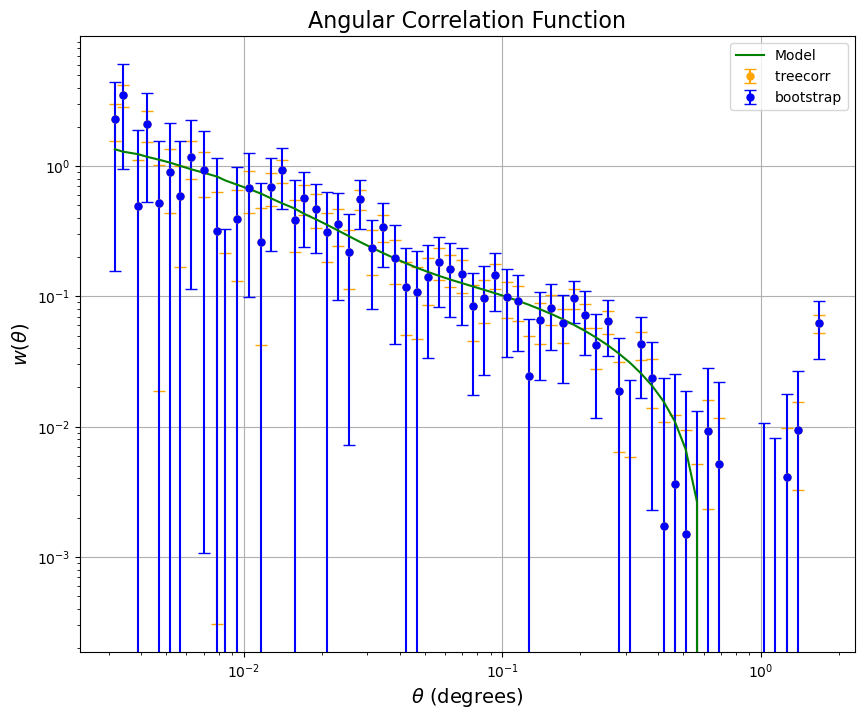

In [16]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='orange', capsize=4, markersize=5, label='treecorr ')  # Careful I changed in config 'var_method' to'shot', so this is Poisson noise

plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors_bootstrap, fmt='o', color='blue', capsize=4, markersize=5, label='bootstrap')


plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

plt.legend()
plt.grid(True)
plt.show()

In [17]:
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

N = len(subsample.filtered_catalog)  # Number of galaxies in the subsample
print(f"Number of galaxies in subsample: {results['N']}")

IC = bias_estimator.integral_constraint(xi_m, results['rr_counts'])

print("\nSubsample Information:")
print(f"  - Redshift range: {subsample.z_min} ≤ z < {subsample.z_max}")
print(f"  - Stellar mass range: {subsample.SM_min} ≤ SM < {subsample.SM_max}")
print(f"  - Number of galaxies: {N}")
print(f"  - Bias: {bias_values[0]:.3f} ± {bias_errors[0]:.3f}")


Number of galaxies in subsample: 927

Subsample Information:
  - Redshift range: 0.6 ≤ z < 0.7
  - Stellar mass range: 10.5 ≤ SM < 11
  - Number of galaxies: 927
  - Bias: 1.432 ± 0.040


# Now I am trying all 4 fields

In [18]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
     },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
        
}}


areas = {
    "SN-X3": 1.297,
    "SN-C3": 1.340,
    "SN-E2": 1.103,
    "COSMOS": 0.893
}

z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

bias_results = {}

for field, paths in fields.items():
    print(f"🔹 Processing field: {field}")

    # Load galaxy catalog & masked catalog
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))

    # Join tables on ID
    catalog = join(catalog, masked, keys='id')
    catalog.rename_column('ra_1', 'ra')
    catalog.rename_column('dec_1', 'dec')

    # Load randoms
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Select subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                             z_min=z_min, z_max=z_max, 
                             SM_min=SM_min, SM_max=SM_max, 
                             config=config)

    results = subsample.get_results()
    theta_values = results['theta']
    theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)


    bias_estimator = dv.BiasEstimator(
        xi_g=results['xi_g'],
        xi_m=results['xi_m'],
        w_theta_list=[results['w_theta']], 
        w_theta_error_list=[np.sqrt(results['var_w_theta_bootstrap'])], 
        sum_rr_list=[results['rr_counts']], 
        mask=theta_mask
    )

    bias_values, bias_errors = bias_estimator.estimate_bias()
    
    bias_results[field] = {
        "bias_values": bias_values,
        "bias_errors": bias_errors
    }

    print(f"Bias for {field}: {bias_values}")
    print(f" Bias errors for {field}: {bias_errors}")
    print()
    
    N = results['N']
    print(f"Number of galaxies in {field}: {N}")

    # Compute nav
    area = areas[field]  # Select the corresponding area for the field
    nav = np.average(N / area)
    print(f'nav for {field}:', nav)

    # Compute overdensity
    del_b = ((N / area) / nav - 1) / bias_values
    print(f"Overdensity (del_b) for {field}: {del_b}")
    print()




🔹 Processing field: SN-X3
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.
Theta: [0.00311337 0.00347073 0.00384008 0.00423402 0.00470884 0.00530735
 0.00572218 0.00628077 0.00697666 0.00765434 0.00860086 0.00938489
 0.01044329 0.01153028 0.01274162 0.01416764 0.01574739 0.01741947
 0.01898684 0.02103303 0.02312342 0.0256537  0.02839634 0.03127639
 0.03461879 0.03821236 0.0424298  0.04660419 0.05151469 0.05690401
 0.06308635 0.06964853 0.07693703 0.08484386 0.09397139 0.10380232
 0.1146443  0.12674838 0.13983089 0.15485815 0.1709703  0.18881582
 0.20868179 0.2302726  0.25464738 0.28128366 0.31096346 0.34364311
 0.37934548 0.41934893 0.46310017 0.51105398 0.56581001 0.62519473
 0.6909427  0.76247383 0.84231083 0.93171476 1.02670325 1.1339826
 1.25222483 1.38377333 1.52576573 1.6765583 ]
w_theta: [ 1.90444975e-01  1.46006371e+00  2.24982001e+00  1.01046785e+00
  1.24733731e+00 -3.37527387e-01  5.19601469e-01  2.50812081e-01
  1.75992274e

In [19]:

print("\n Bias Comparison Across Fields:")
for field, bias_data in bias_results.items():
    print(f"{field}: Bias = {bias_data['bias_values']}, Errors = {bias_data['bias_errors']}")




 Bias Comparison Across Fields:
SN-X3: Bias = [1.008143199138996], Errors = [0.11203401387190756]
SN-C3: Bias = [1.4262037698155652], Errors = [0.08449338661394509]
SN-E2: Bias = [1.128547523277236], Errors = [0.13291926770605597]
COSMOS: Bias = [1.1777370167975147], Errors = [0.08982790864737929]


## Field areas (sq. deg.):

COSMOS: 0.893
SN-C3: 1.340
SN-E2: 1.103
SN-X3: 1.297


density average = N/areas

### ^ bigger errors in X3 and E2 bc more of the area was thrown away so we have less galaxies so the errors on the corrlation functions are bigger aka bigger errors in the bias

In [20]:
z_ranges = [(0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8)] 
SM_min, SM_max = 10.5, 11  

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # 'shot' for faster, 'bootstrap' for more accurate but slower results
}

# Dictionary to store bias results for each field and redshift range
bias_results = {}

# Loop over each field
for field, paths in fields.items():
    print(f"🔹 Processing field: {field}")

    # Load galaxy catalog & masked catalog
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))

    # Join the catalogs
    catalog = join(catalog, masked, keys='id')
    catalog.rename_column('ra_1', 'ra')
    catalog.rename_column('dec_1', 'dec')

    # Load randoms catalog
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Loop over each redshift range and create subsample
    for z_min, z_max in z_ranges:
        print(f"  Processing z range: {z_min} to {z_max}")

        # Create subsample for this redshift range
        subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                                 z_min=z_min, z_max=z_max, 
                                 SM_min=SM_min, SM_max=SM_max, 
                                 config=config)

        # Get the results for the subsample
        results = subsample.get_results()

        # Define theta values and apply mask for the bias estimator
        theta_values = results['theta']
        theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)

        # Compute bias for this subsample
        bias_estimator = dv.BiasEstimator(
            xi_g=results['xi_g'],
            xi_m=results['xi_m'],
            w_theta_list=[results['w_theta']], 
            w_theta_error_list=[np.sqrt(results['var_w_theta_bootstrap'])], 
            sum_rr_list=[results['rr_counts']], 
            mask=theta_mask
        )

        bias_values, bias_errors = bias_estimator.estimate_bias()

        # Store the results for each field and redshift range
        bias_results_key = f"{field}_z{z_min}-{z_max}"
        bias_results[bias_results_key] = {
            "bias_values": bias_values,
            "bias_errors": bias_errors
        }

        print(f"  Bias for z range {z_min}-{z_max}: {bias_values}")
        print(f"  Bias errors for z range {z_min}-{z_max}: {bias_errors}")
        print()




🔹 Processing field: SN-X3
  Processing z range: 0.3 to 0.4
The following patch numbers have no objects: {23}
This may be a problem depending on your use case.
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {21}
This may be a problem depending on your use case.
The following patch numbers have no objects: {18}
This may be a problem depending on your use case.
The following patch numbers have no objects: {44}
This may be a problem depending on your use case.
The following patch numbers have no objects: {19}
This may be a problem depending on your use case.
The following patch numbers have no objects: {19}
This may be a problem depending on your use case.
The following patch numbers have no objects: {24}
This may be a problem depending on your use case.
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.
Theta: [0.00310444 0.00332441 0.00384993 

TypeError: unsupported format string passed to list.__format__

In [28]:
print("\n📊 Final Bias Results:\n")

# Get all fields from your bias_results keys
fields_in_results = set(key.split('_z')[0] for key in bias_results.keys())

for field in sorted(fields_in_results):
    print(f"🔸 Field: {field}")
    
    # Find all redshift entries for this field
    field_entries = {key: val for key, val in bias_results.items() if key.startswith(field)}

    for key, bias_data in sorted(field_entries.items()):
        # Extract redshift range from the key
        z_range = key.split('_z')[1]  # e.g., '0.3-0.4'

        # Unpack bias value and error (assuming one per subsample)
        b = bias_data['bias_values'][0]
        be = bias_data['bias_errors'][0]

        print(f"   z range {z_range}: Bias = {b:.2f}, Error = {be:.2f}")
    
    print()  # Blank line between fields



📊 Final Bias Results:

🔸 Field: COSMOS
   z range 0.3-0.4: Bias = 0.94, Error = 0.09
   z range 0.4-0.5: Bias = 1.03, Error = 0.09
   z range 0.5-0.6: Bias = 1.06, Error = 0.10
   z range 0.6-0.7: Bias = 1.19, Error = 0.09
   z range 0.7-0.8: Bias = 1.37, Error = 0.10

🔸 Field: SN-C3
   z range 0.3-0.4: Bias = 1.28, Error = 0.10
   z range 0.4-0.5: Bias = 1.01, Error = 0.13
   z range 0.5-0.6: Bias = 1.17, Error = 0.11
   z range 0.6-0.7: Bias = 1.43, Error = 0.08
   z range 0.7-0.8: Bias = 1.38, Error = 0.09

🔸 Field: SN-E2
   z range 0.3-0.4: Bias = 1.45, Error = 0.07
   z range 0.4-0.5: Bias = 1.23, Error = 0.08
   z range 0.5-0.6: Bias = 1.08, Error = 0.11
   z range 0.6-0.7: Bias = 1.12, Error = 0.13
   z range 0.7-0.8: Bias = 0.65, Error = 0.21

🔸 Field: SN-X3
   z range 0.3-0.4: Bias = 1.14, Error = 0.08
   z range 0.4-0.5: Bias = 1.10, Error = 0.10
   z range 0.5-0.6: Bias = 0.86, Error = 0.12
   z range 0.6-0.7: Bias = 1.02, Error = 0.11
   z range 0.7-0.8: Bias = 1.48, Error

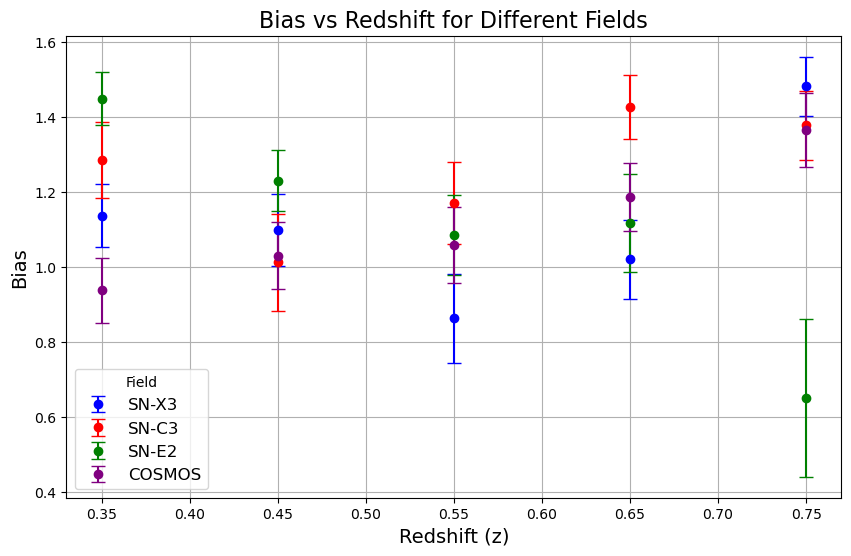

In [29]:

field_colors = {
    "SN-X3": "blue",
    "SN-C3": "red",
    "SN-E2": "green",
    "COSMOS": "purple"
}

plt.figure(figsize=(10, 6))

# Dictionary to track labels (to avoid duplicates in the legend)
field_labels = {}

# Loop over the bias results to plot each field's biases against redshift
for field_z, bias_data in bias_results.items():
    bias_values = bias_data['bias_values']
    bias_errors = bias_data['bias_errors']
    
    # Extract the redshift range from the field_z key
    field, z_range = field_z.split('_z')
    z_min, z_max = map(float, z_range.split('-'))
    
    # Average redshift for the range 
    z_avg = (z_min + z_max) / 2

    # Use the predefined color for the field
    color = field_colors.get(field, "black")  # Default to black if field not in dictionary

    # Only add the field to the legend once
    if field not in field_labels:
        plt.errorbar(z_avg, bias_values, yerr=bias_errors, fmt='o', color=color, label=field, capsize=5)
        field_labels[field] = True  # Mark as added
    else:
        plt.errorbar(z_avg, bias_values, yerr=bias_errors, fmt='o', color=color, capsize=5)

# Customize the plot
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Bias', fontsize=14)
plt.title('Bias vs Redshift for Different Fields', fontsize=16)
plt.legend(title='Field', fontsize=12)
plt.grid(True)
plt.show()

